<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PlotEnergies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
# !pip install -q https://github.com/conda-incubator/condacolab/archive/main.zip
# import condacolab
# condacolab.install()

In [2]:
%%capture
import sys

!{sys.executable} -m pip install jscatter
!{sys.executable} -m pip install ipympl
#!{sys.executable} -m pip install -i https://pypi.anaconda.org/ambermd/simple pytraj 
#!mamba install -c conda-forge openbabel -y
#!pip install --upgrade MDAnalysis
#!mamba install -c conda-forge ambertools -y

# Import libraries

In [3]:
%matplotlib ipympl

import jscatter as js
import matplotlib.pyplot as plt
import os 
import numpy as np
from google.colab import output
import pandas as pd
import seaborn as sb 
import matplotlib.gridspec as gridspec
#import pytraj as pt

js.usempl(True)  # use matplotlib
#js.usempl(False) # default, use grace on your computer with xmgrace in external window.


output.enable_custom_widget_manager()

Using  mpl


# Import Files

In [ ]:
#@title Import files from google
#from google.colab import drive

#drive.flush_and_unmount()
#drive.mount('/content/drive', force_remount=False)

In [4]:
#@title Github

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

rm: cannot remove '/content/MD-SCPI': No such file or directory
Cloning into 'MD-SCPI'...
remote: Enumerating objects: 1557, done.
remote: Counting objects: 100% (586/586), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 1557 (delta 257), reused 545 (delta 234), pack-reused 971
Receiving objects: 100% (1557/1557), 248.98 MiB | 18.91 MiB/s, done.
Resolving deltas: 100% (670/670), done.
Updating files: 100% (284/284), done.


In [49]:
work_directories = ['/content/MD-SCPI/PDBs/MD/COL/data', '/content/MD-SCPI/PDBs/MD/AS4/data', '/content/MD-SCPI/PDBs/MD/STR/data']

#files = os.listdir(work_directories[0])
#ligand_files = np.array([file for file in files if 'ligand' in file])
#[print(i, ligand_files[i]) for i in range(ligand_files.size)];

ligand_files_interesting = ['ligand-protein.dat', 'ligand-environment.dat', 'ligand-GLN51.dat', 'ligand-ASN45.dat', 'ligand-ARG92.dat']#, 'ligand-THR220.dat']
colors = ['black', 'blue', 'orange', 'red', 'green', 'purple']

dt = 0.002*1e3  # ste time in ns

In [46]:
# plt.close()
# energies = pd.DataFrame()

# for file in ligand_files_interesting:
#   data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
#   energy = pd.DataFrame({'time':data.X/dt, 'energy':data.Y + data.eY, 'with':[file[7:-4]]*data.Y.size})
#   energies = energies.append(energy, ignore_index=True)

# g = sb.jointplot(data=energies, x="time", y="energy", hue="with", xlim=(-2,502), height=10, ratio=4) #marginal_kws=dict(bins=30))
# g.ax_marg_x.remove()

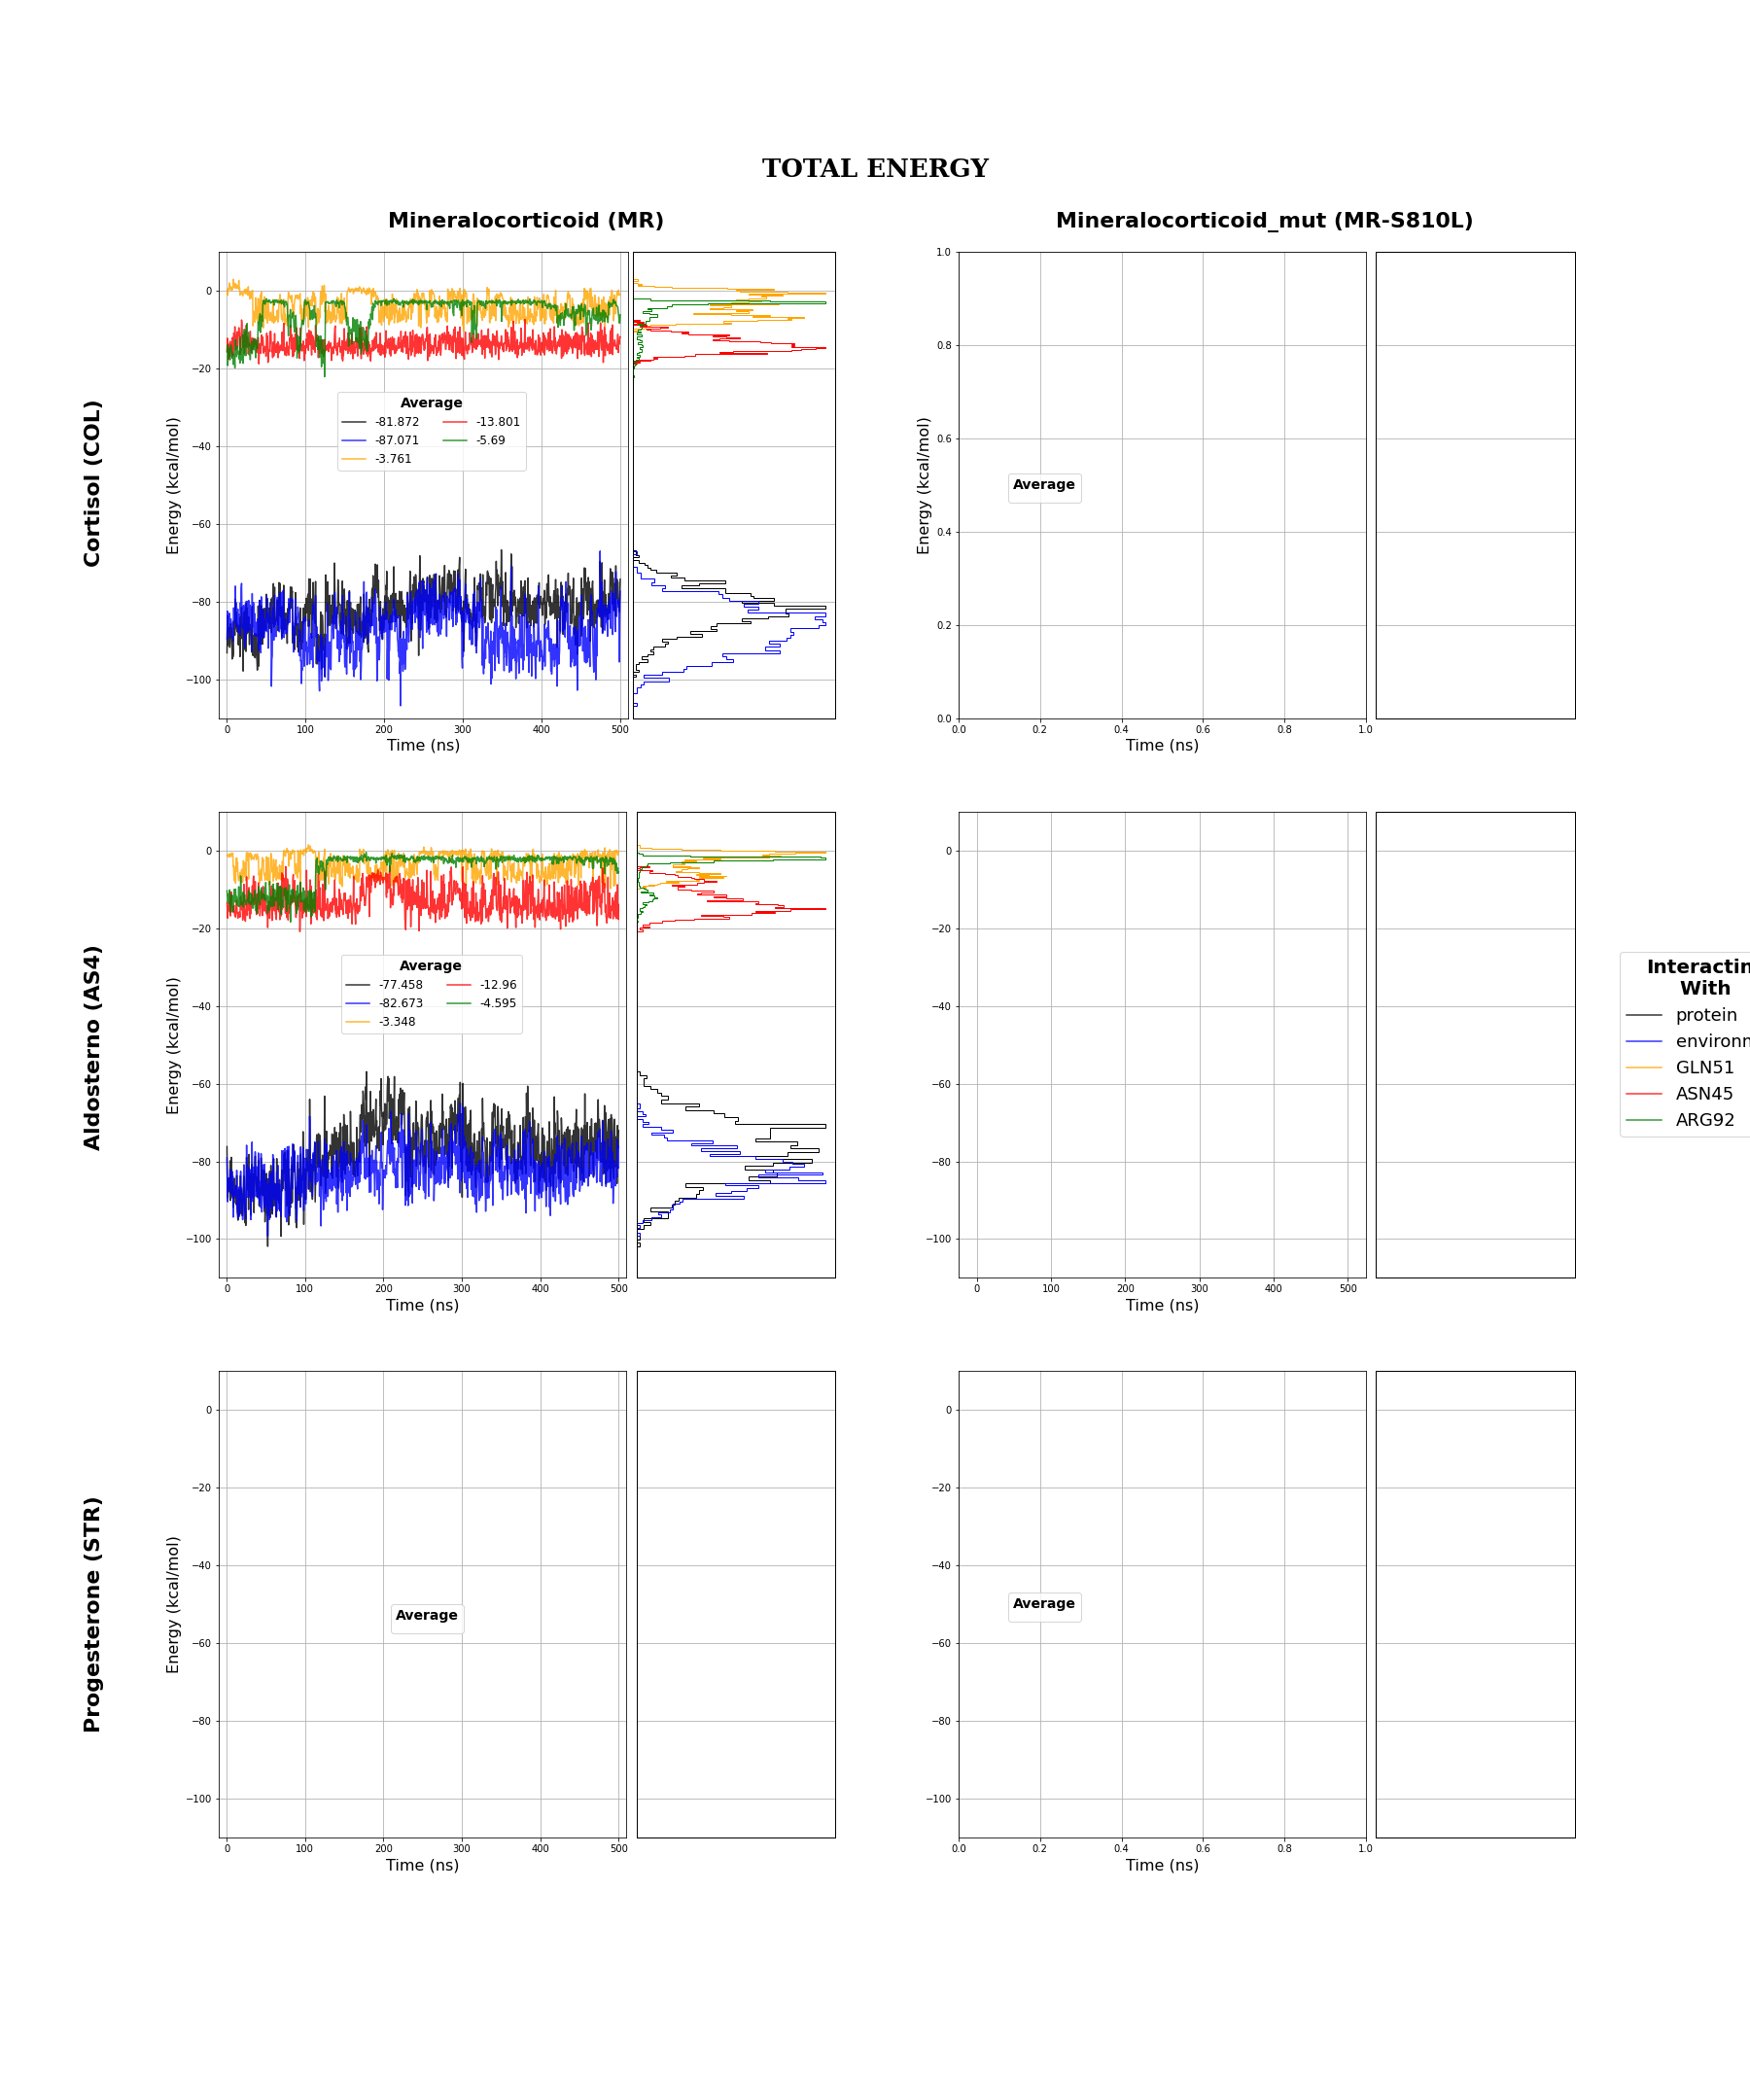

In [95]:
def RemoveBox(ax):
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

def PlotEnergies(work_directories, figsize=(25,30), bins=100, bins_cum=50):
  plt.close()
  fig = plt.figure(figsize=figsize)
  gs0 = gridspec.GridSpec(3, 2, figure=fig)

  # ----------------------------------------- cortisol -----------------------------------------
  gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,0], wspace=0.025)
  ax_main = plt.subplot(gs00[0:2, :2])
  ax_yDist = plt.subplot(gs00[:1, 2],sharey=ax_main)
  ax_main.grid(True); ax_yDist.grid(axis='y')

  c=0
  for i in range(len(ligand_files_interesting)):
    data=js.dA(os.path.join(work_directories[0], ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    ax_main.plot(x,y,'-', color=colors[i], alpha=0.8, label=round(np.average(y),3))#ligand_files_interesting[i][7:-4])
    
    #ax_yDist.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist = ax_yDist.twiny()
    ax_yCumDist.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    
    c+=1

  ax_main.text(-180, -70,  'Cortisol (COL)',     fontsize='22', fontweight='bold', rotation=90)
  ax_main.text(-180, -220, 'Aldosterno (AS4)',   fontsize='22', fontweight='bold', rotation=90)
  ax_main.text(-180, -370, 'Progesterone (STR)', fontsize='22', fontweight='bold', rotation=90)

  ax_main.set_title('Mineralocorticoid (MR)', fontweight='bold', fontsize='22', pad=25, x=0.75)
  ax_main.set_xlabel("Time (ns)", fontsize='16')
  ax_main.set_ylabel("Energy (kcal/mol)", fontsize='16')
  ax_main.legend(bbox_to_anchor=(0.75, .7), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 

  #ax_yDist.set(xlabel='count')
  #ax_yCumDist.tick_params('x', colors='r')
  #ax_yCumDist.set_xlabel('cumulative',color='r')

  # ----------------------------------------- aldosterone -----------------------------------------
  gs01 = gs0[1,0].subgridspec(1, 3, wspace=0.05)
  ax_main_1 = plt.subplot(gs01[0:2, :2])
  ax_yDist_1 = plt.subplot(gs01[:1, 2],sharey=ax_main_1)
  ax_main_1.grid(True); ax_yDist_1.grid(axis='y')

  for i in range(len(ligand_files_interesting)):
    data=js.dA(os.path.join(work_directories[1], ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    ax_main_1.plot(x,y,'-',  color=colors[i], alpha=0.8, label=round(np.average(y),3)) #label=ligand_files_interesting[i][7:-4],

    #ax_yDist_1.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist_1 = ax_yDist_1.twiny()
    ax_yCumDist_1.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    ax_yCumDist_1.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_1.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    #RemoveBox(ax_yDist_1); RemoveBox(ax_yCumDist_1);

  #ax_main_1.set_title('            Cortisol (COL)', fontweight='normal', fontsize='20', pad=15)
  ax_main_1.set_xlabel("Time (ns)", fontsize='16')
  ax_main_1.set_ylabel("Energy (kcal/mol)", fontsize='16')
  ax_main_1.sharey(ax_main); ax_main_1.sharex(ax_main)
  ax_main_1.legend(bbox_to_anchor=(0.3, .525), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  #ax_yDist_1.axis('off');    ax_yCumDist_1.axis('off')
  
  #ax_main.set_ylabel("Total Energy (kcal/mol)", fontsize='16')

  #ax_main_1.legend(bbox_to_anchor=(1.9, .6), title='$\\bf{With:}$', fontsize='14', title_fontsize='16', borderaxespad=0.)

  # ----------------------------------------- progesterone -----------------------------------------
  gs01 = gs0[2,0].subgridspec(1, 3, wspace=0.05)
  ax_main_4 = plt.subplot(gs01[0:2, :2])
  ax_yDist_4 = plt.subplot(gs01[:1, 2],sharey=ax_main_4)
  ax_main_4.grid(True); ax_yDist_4.grid(axis='y')

  for i in range(len(ligand_files_interesting)):
    #data=js.dA(os.path.join(work_directories[1], ligand_files_interesting[i])) 
    #x, y = data.X/dt, data.Y + data.eY
    #ax_main_4.plot(x,y,'-', color=colors[i], alpha=0.8, label=round(np.average(y),3)) #, label=ligand_files_interesting[i][7:-4]

    #ax_yDist_4.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist_4 = ax_yDist_4.twiny()
    #ax_yCumDist_4.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    #ax_yCumDist_4.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yCumDist_4.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_4.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    #RemoveBox(ax_yDist_4); RemoveBox(ax_yCumDist_4);

  #ax_main_4.set_title('            Progesterone (STR)', fontweight='normal', fontsize='20', pad=15)
  ax_main_4.legend(bbox_to_anchor=(0.6, .5), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  ax_main_4.set_xlabel("Time (ns)", fontsize='16')
  ax_main_4.set_ylabel("Energy (kcal/mol)", fontsize='16')
  ax_main_4.sharey(ax_main); ax_main_4.sharex(ax_main)
  #ax_yDist_1.axis('off');    ax_yCumDist_1.axis('off')
  
  #ax_main.set_ylabel("Total Energy (kcal/mol)", fontsize='16')

  ##########################################################################################################################################
  # ----------------------------------------- MUTATIONS -----------------------------------------
  ##########################################################################################################################################
  # ----------------------------------------- cortisol -----------------------------------------
  gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0,1], wspace=0.05)
  ax_main_2 = plt.subplot(gs00[0:2, :2])

  ax_yDist_2 = plt.subplot(gs00[:1, 2],sharey=ax_main_2)
  ax_main_2.grid(True); ax_yDist_2.grid(axis='y')

  for i in range(len(ligand_files_interesting)):
  #   data=js.dA(os.path.join(work_directories[2], ligand_files_interesting[i])) 
  #   x, y = data.X/dt, data.Y + data.eY
  #   ax_main_2.plot(x,y,'-', label=round(np.average(y),3), color=colors[c], alpha=0.8)

  #   ax_yDist_2.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist_2 = ax_yDist_2.twiny()
  #   ax_yCumDist_2.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
  #  ax_yCumDist_2.tick_params(top=False, labeltop=False, left=False, labelleft=False)
    ax_yCumDist_2.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_2.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    
  ax_main_2.legend(bbox_to_anchor=(0.3, .525), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  ax_main_2.set_title('Mineralocorticoid_mut (MR-S810L)', fontweight='bold', fontsize='22', pad=25, x=0.75)
  ax_main_2.set_xlabel("Time (ns)", fontsize='16')
  ax_main_2.set_ylabel("Energy (kcal/mol)", fontsize='16')
  #ax_main.legend(bbox_to_anchor=(1.75, .5), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.)

  #ax_yDist.set(xlabel='count')
  #ax_yCumDist.tick_params('x', colors='r')
  #ax_yCumDist.set_xlabel('cumulative',color='r')

  # ----------------------------------------- aldosterone -----------------------------------------
  gs01 = gs0[1,1].subgridspec(1, 3, wspace=0.05)
  ax_main_3 = plt.subplot(gs01[0:2, :2])
  ax_yDist_3 = plt.subplot(gs01[:1, 2],sharey=ax_main_1)
  ax_main_3.grid(True); ax_yDist_3.grid(axis='y')
  lines, lines1 = [], []

  for i in range(len(ligand_files_interesting)):
    data=js.dA(os.path.join(work_directories[1], ligand_files_interesting[i])) 
    x, y = data.X/dt, data.Y + data.eY
    line,  = ax_main_3.plot(x,y+1e4, '-', label=ligand_files_interesting[i][7:-4], color=colors[i], alpha=0.8)
    #line1, = ax_main_3.plot(x,y, '-', label=round(np.average(y),3), color=colors[i], alpha=0.8)
    lines.append(line); #lines1.append(line1)
    
    #ax_yDist_3.hist(y,bins=bins,orientation='horizontal', align='mid', label=ligand_files_interesting[i][7:-4], stacked=False, density=True, color=colors[i] )
    ax_yCumDist_3 = ax_yDist_3.twiny()
    #ax_yCumDist_3.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True, label=ligand_files_interesting[i][7:-4], color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    ax_yCumDist_3.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_3.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    #RemoveBox(ax_yDist_3); #RemoveBox(ax_yCumDist_3);

  #ax_main_3.legend(bbox_to_anchor=(0.3, .525), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  #ax_main_3.set_title('            Cortisol (COL)', fontweight='normal', fontsize='20')
  ax_main_3.set_xlabel("Time (ns)", fontsize='16')
  ax_main_3.sharey(ax_main)

  # ------ double legend -------
  #legend = ax_main_3.legend(handles=lines1, bbox_to_anchor=(0.3, .525), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  #ax_main_3.add_artist(legend)
  ax_main_3.legend(handles=lines, bbox_to_anchor=(2.05, .7), title='Interacting\n     With', fontsize='18', borderaxespad=0., title_fontproperties={'weight':'bold', 'size':'20'})


  # ----------------------------------------- progesterone -----------------------------------------
  gs01 = gs0[2,1].subgridspec(1, 3, wspace=0.05)
  ax_main_5 = plt.subplot(gs01[0:2, :2])
  ax_yDist_5 = plt.subplot(gs01[:1, 2],sharey=ax_main_1)
  ax_main_5.grid(True); ax_yDist_5.grid(axis='y')

  for i in range(len(ligand_files_interesting)):
  #   data=js.dA(os.path.join(work_directories[3], ligand_files_interesting[i])) 
  #   x, y = data.X/dt, data.Y + data.eY
  #   ax_main_5.plot(x,y, '-', label=round(np.average(y),3), color=colors[i], alpha=0.8)

  #   #ax_yDist_5.hist(y,bins=bins,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
    ax_yCumDist_5 = ax_yDist_5.twiny()
  #   ax_yCumDist_5.hist(y,bins=bins_cum,cumulative=False,histtype='step',density=True,color=colors[i],align='mid',orientation='horizontal', lw=1)
    
    ax_yCumDist_5.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)
    ax_yDist_5.tick_params(top=False, labeltop=False, left=False, labelleft=False, bottom=False, labelbottom=False)

    #RemoveBox(ax_yDist_5); #RemoveBox(ax_yCumDist_5);

  ax_main_5.legend(bbox_to_anchor=(0.3, .525), title='Average', fontsize='12', ncol=2, borderaxespad=0., title_fontproperties={'weight':'bold','size':'14'}) #, 
  #ax_main_5.set_title('            Cortisol (COL)', fontweight='normal', fontsize='20')
  ax_main_5.set_xlabel("Time (ns)", fontsize='16')
  ax_main_5.sharey(ax_main)
  
  ax_main.set_ylim((-110, 10)); ax_main.set_xlim((-10, 510))

  plt.suptitle('TOTAL ENERGY', fontweight='bold', fontsize='26', y=0.925, fontfamily='serif')
  plt.show()   #fig.tight_layout()
  return fig

fig = PlotEnergies(work_directories, bins=100, bins_cum=50);
fig.savefig("./Energies.png", transparent=True, bbox_inches='tight')

In [48]:
def PlotsEnergies(work_directory_AS4, work_directory_COL):

  plt.close()
  fig, axs = plt.subplots(1,2,figsize=(20,8))

  # -------------- aldosterone -------------------------
  c = 0
  for file in ligand_files_interesting:
    data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
    axs[0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
    c+=1

  axs[0].set_xlabel('Time (ns)', fontsize='14')
  axs[0].set_ylabel('Kcal/mol', fontsize='14')
  axs[0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
  axs[0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

  # ------------------ cortisol --------------------------
  c=0
  for file in ligand_files_interesting:
    data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
    axs[1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
    c+=1

  axs[1].set_xlabel('Time (ns)', fontsize='14')
  axs[1].set_ylabel('Kcal/mol', fontsize='14')
  legend = axs[1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
  axs[1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
  #axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

  axs[1].sharey(axs[0]); axs[1].sharex(axs[0]) # share x and y axis

  #plt.rcParams['legend.title_fontweight'] = 'bold'

  # axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
  plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
  fig.tight_layout()
  plt.show()

  return fig

In [ ]:
#sb.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

In [ ]:
interaction = 'ligand-ASN45.dat'

def PlotAllEnergies(interaction):
  data=js.dA(os.path.join(work_directory_AS4, interaction), ignore='#')

  fig = plt.figure(figsize=(11,6))
  plt.plot(data.X, data.Y, label='Elec')
  plt.plot(data.X, data.eY, label="VDW")
  plt.plot(data.X, data.Y + data.eY, label='Total')
  plt.xlabel('Frame'); plt.ylabel('K Cal')
  plt.legend(bbox_to_anchor=(1.05, .5), title='Energy0')
  plt.title('Energies of ligand-ASN45.dat', fontweight='bold', fontsize='18')
  
  plt.show()

  return fig

In [ ]:
#help(data)

In [ ]:
#p=js.mplot()
#p.plot(data)